# 🐾 African Wildlife Image Classifier with CNN

## 📌 Problem Statement
### Comparing an image classification model with custom Convolutional Neural Networks (CNNs) and pretrained MobileNetV2 to identify wildlife species from images taken in African nature reserves. 



## 🎯 Goal & 
### Classify images of animals such as elephants, lions, zebras, etc., with high accuracy. The dataset used in this project is *[African Wildlife](https://www.kaggle.com/datasets/biancaferreira/african-wildlife)* on kaggle. 

In [2]:
# Installing required libraries 
!pip install split-folders

In [39]:
# Importing all the required libariries for project 
import os
import random
import numpy as np
import pandas as pd
import splitfolders
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout, Input,
                                     GlobalAveragePooling2D,BatchNormalization, Flatten, Dense)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
# Setting base directory to our dataset 
base_dir  = '/kaggle/input/african-wildlife/'
os.listdir(base_dir)

['buffalo', 'elephant', 'zebra', 'rhino']

In [5]:
#  Splitting data for Training, Validation and Testing in to respective folders 
input_folder = "/kaggle/input/african-wildlife/"   
output_folder = "/kaggle/working/split_data"                    

# Split into train/val/test = 70% / 20% / 10%
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.7, 0.2, 0.1), move=False)

Copying files: 3008 files [00:39, 75.69 files/s] 


In [6]:
# Making Sure there is no data leakage in our splits
train_dataset = set(os.listdir('/kaggle/working/split_data/train/elephant'))
val_dataset = set(os.listdir('/kaggle/working/split_data/val/elephant'))
test_dataset = set(os.listdir('/kaggle/working/split_data/test/elephant'))

overlap_train_val = train_dataset & val_dataset
overlap_train_test = train_dataset & test_dataset
overlap_val_test = val_dataset & test_dataset

print("Train/Val Overlap:", len(overlap_train_val))
print("Train/Test Overlap:", len(overlap_train_test))
print("Val/Test Overlap:", len(overlap_val_test))

Train/Val Overlap: 0
Train/Test Overlap: 0
Val/Test Overlap: 0


In [7]:
# Loading images for Training, Validition and Testing with preprocessing along with hot-vector encoding to the class

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/kaggle/working/split_data/train', target_size=(128, 128), batch_size=32, class_mode='categorical')

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/kaggle/working/split_data/val', target_size=(128, 128), batch_size=32, class_mode='categorical')

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/kaggle/working/split_data/test', target_size=(128, 128), batch_size=32, class_mode='categorical', shuffle=False)

Found 1056 images belonging to 4 classes.
Found 288 images belonging to 4 classes.
Found 160 images belonging to 4 classes.


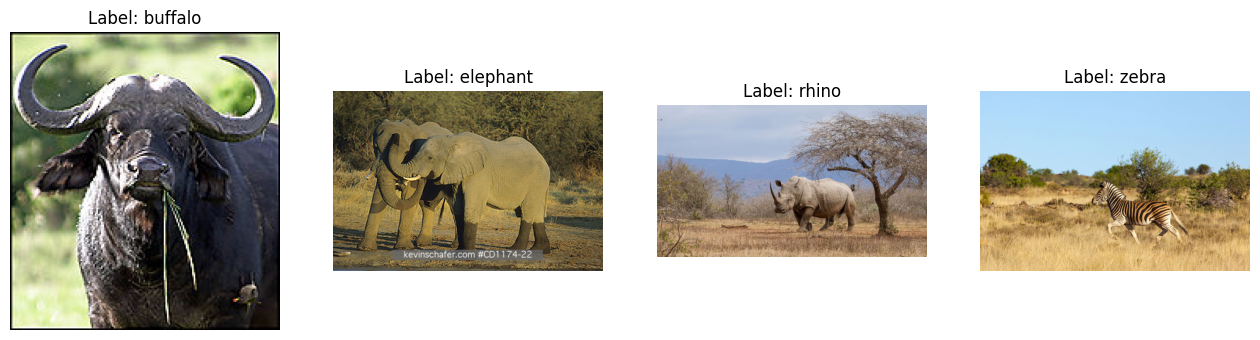

In [10]:
# Visulizing random training images Path to the training folder
train_dir = '/kaggle/working/split_data/train'

class_names = sorted(os.listdir(train_dir))

# Image extensions to avoid other formats
image_extensions = ['.jpg', '.jpeg', '.png']

# Plotting
plt.figure(figsize=(16, 4))

for i, class_name in enumerate(class_names[:4]):  # Take only 4 categories
    class_folder = os.path.join(train_dir, class_name)

    # List only image files (skip txt or others)
    image_files = [f for f in os.listdir(class_folder)
                   if os.path.splitext(f)[1].lower() in image_extensions]

   # Skipping if no images 
    if not image_files:
        continue

    # Randomly select image
    random_image = random.choice(image_files)
    image_path = os.path.join(class_folder, random_image)

    # Plotting the images
    img = mpimg.imread(image_path)
    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {class_name}")
    plt.axis('off')

In [22]:
# Custom CNN Architecture with parameters 
model_custom_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])



In [13]:
# Compile custom model with adam and related parameters 
model_custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Data augmentation after trial and error to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/working/split_data/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '/kaggle/working/split_data/val',
    target_size=(128, 128),
    batch_size=32,
)

# New optimizer 
optimizer = Adam(learning_rate=0.001)

# Reducing learning if no improvement 
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Early stopping the model if it starts getting worse
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

# Compile with improved setup
model_custom_cnn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Custom CNN Model:")
print(model_custom_cnn.summary())

Found 1056 images belonging to 4 classes.
Found 288 images belonging to 4 classes.
Custom CNN Model:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,437,700 (16.93 MB)

 Trainable params: 4,437,700 (16.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
# Training model 
history_custom_cnn = model_custom_cnn.fit(
    train_generator,
    epochs=60,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 22s 485ms/step - accuracy: 0.2815 - loss: 1.4753 - val_accuracy: 0.2917 - val_loss: 1.3419 - learning_rate: 0.0010
Epoch 2/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 472ms/step - accuracy: 0.3835 - loss: 1.3044 - val_accuracy: 0.4792 - val_loss: 1.2910 - learning_rate: 0.0010
Epoch 3/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 474ms/step - accuracy: 0.4520 - loss: 1.1235 - val_accuracy: 0.4167 - val_loss: 1.5943 - learning_rate: 0.0010
Epoch 4/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 512ms/step - accuracy: 0.5191 - loss: 1.0486 - val_accuracy: 0.5312 - val_loss: 1.3619 - learning_rate: 0.0010
Epoch 5/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step - accuracy: 0.5896 - loss: 0.9485 - val_accuracy: 0.5382 - val_loss: 1.4626 - learning_rate: 0.0010
Epoch 6/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 472ms/step - accuracy: 0.5835 - loss: 0.9346 - val_accuracy: 0.6319 - val_loss: 1.2414 - learning_rate: 0.0010
Epoch 7/60
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 464ms/step - accuracy: 0.6290 - loss: 0.

In [27]:
# Testing model 

pred_prob = model_custom_cnn.predict(test_generator)
y_pred = np.argmax(pred_prob, axis=1)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step


In [28]:
# True Labes
y_true = test_generator.classes

In [29]:
class_names = list(test_generator.class_indices.keys())

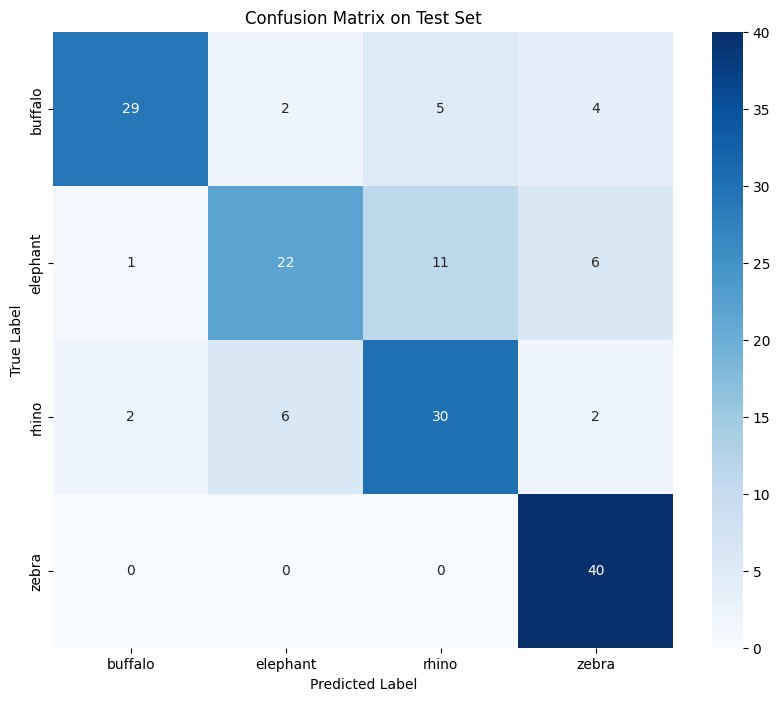

In [31]:
# Confusion Matrx 
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion Matrix

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

In [32]:
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

     buffalo       0.91      0.72      0.81        40
    elephant       0.73      0.55      0.63        40
       rhino       0.65      0.75      0.70        40
       zebra       0.77      1.00      0.87        40

    accuracy                           0.76       160
   macro avg       0.77      0.76      0.75       160
weighted avg       0.77      0.76      0.75       160



## Lets Train this model on MobileNetV2



In [37]:
# Creating a base model 

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(128, 128, 3))
)
base_model.trainable = False  # freeze weights


/tmp/ipykernel_35/3874869964.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [40]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [41]:
history_mobilenet = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 616ms/step - accuracy: 0.3490 - loss: 2.1305 - val_accuracy: 0.6562 - val_loss: 0.7998 - learning_rate: 1.0000e-04
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 473ms/step - accuracy: 0.5135 - loss: 1.2808 - val_accuracy: 0.7674 - val_loss: 0.5340 - learning_rate: 1.0000e-04
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 469ms/step - accuracy: 0.5822 - loss: 1.0954 - val_accuracy: 0.8333 - val_loss: 0.4173 - learning_rate: 1.0000e-04
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.6577 - loss: 0.8640 - val_accuracy: 0.8438 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 482ms/step - accuracy: 0.6332 - loss: 0.9126 - val_accuracy: 0.8750 - val_loss: 0.3373 - learning_rate: 1.0000e-04
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step - accuracy: 0.6793 - loss: 0.7898 - val_accuracy: 0.8785 - val_loss: 0.3195 - learning_rate: 1.0000e-04
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - accuracy: 0.70

In [42]:
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_51']
Received: inputs=Tensor(shape=(32, 128, 128, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step
              precision    recall  f1-score   support

     buffalo       0.94      0.80      0.86        40
    elephant       0.82      0.82      0.82        40
       rhino       0.78      0.90      0.84        40
       zebra       0.95      0.95      0.95        40

    accuracy                           0.87       160
   macro avg       0.87      0.87      0.87       160
weighted avg       0.87      0.87      0.87       160



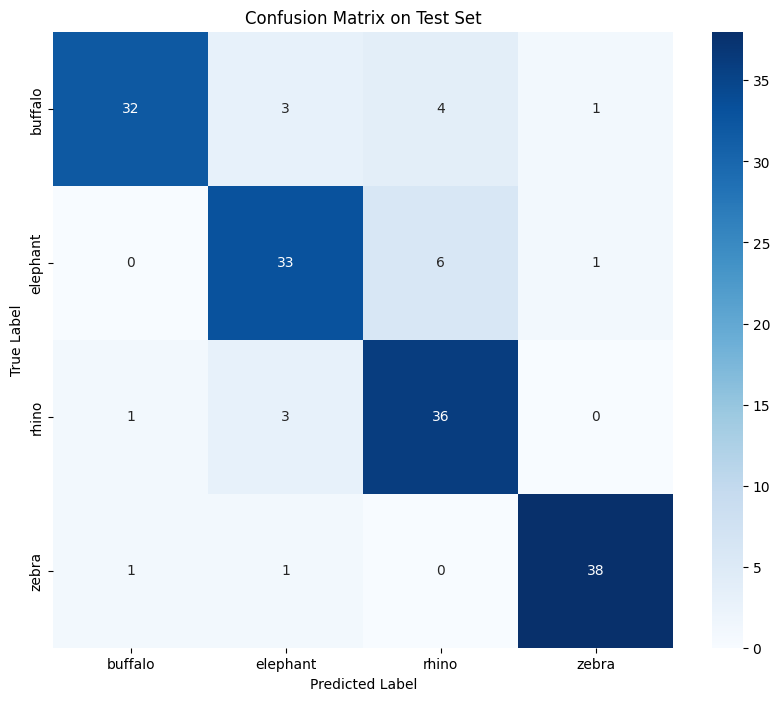

In [43]:
# Confusion Matrx 
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion Matrix

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

## Conclusion 

In this study, we compared a custom-built Convolutional Neural Network (CNN) with a MobileNetV2-based transfer learning model for African wildlife image classification. The results clearly demonstrate that MobileNetV2 significantly outperforms the custom CNN in terms of validation accuracy and generalization.

This outcome highlights the strength of transfer learning in modern machine learning workflows. By leveraging a pretrained model such as MobileNetV2, which has already learned rich features from a large dataset (ImageNet), we were able to achieve higher accuracy with limited training data. This approach not only reduced training time but also improved performance, confirming that pretrained models can deliver more robust and reliable results compared to models trained from scratch, especially when working with small to medium-sized datasets.

